In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
import glob
import pickle
from pickle import load
from time import time
from keras.layers import LSTM, Embedding,Dense,Dropout
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tqdm.notebook import tqdm
import random
from gtts import gTTS
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

The provided Python code defines a function named `load_doc` that reads and loads text data from a specified file. This function opens the file in read-only mode, reads the entire content, and then closes the file. The code demonstrates how to use this function by specifying the `filename` variable with the path to the target file and calling `load_doc` with the `filename` as an argument. The resulting text data is stored in the `doc` variable. This code is a typical approach for reading the contents of a file in Python, making it useful for tasks such as text file processing and data extraction.


In [2]:
def load_doc(filename):
    file = open(filename, 'r') # open the file as read only
    text = file.read() # read all text
    file.close()
    return text
filename = "/home/aakash/Documents/Automated_Image_Captioning-master/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
doc = load_doc(filename)

The code defines a Python function called `load_descriptions` that processes text data typically used in image captioning datasets. It reads the text data from a document and organizes it into a structured format, creating a mapping between image IDs and their respective descriptions. The function splits the text data into lines, extracts image IDs and descriptions, cleans the image IDs by removing file extensions, and stores the descriptions in a dictionary. Each image ID is associated with a list of descriptions. After processing the entire text document, the code returns this structured mapping.

In [3]:
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split() # split line by white space
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:] # take the first token as the image id, the rest as the description
        image_id = image_id.split('.')[0] # extract filename from image id
        image_desc = ' '.join(image_desc) # convert description tokens back to string
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


The code defines a function called `clean_descriptions` that is designed to process and clean textual descriptions associated with images. It takes a dictionary of image IDs and their respective lists of descriptions as input. Within the function, a translation table is created to remove punctuation marks from the text. It then iterates through each description in the dictionary, tokenizes the text, converts all words to lowercase, and removes punctuation from each token. Furthermore, it filters out words with a length less than or equal to one and removes tokens that contain numbers. Finally, the cleaned tokens are joined back together to form a cleaned description string, which is then stored back in the dictionary.

In [4]:
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation) # prepare translation table for removing punctuation
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split() # tokenize
            desc = [word.lower() for word in desc] # convert to lower case
            desc = [w.translate(table) for w in desc] # remove punctuation from each token
            desc = [word for word in desc if len(word) > 1] # remove hanging 's' and 'a'
            desc = [word for word in desc if word.isalpha()] # remove tokens with numbers in them
            desc_list[i] = ' '.join(desc) # store as string
clean_descriptions(descriptions)

The code defines a function named `to_vocabulary` with the purpose of converting the loaded descriptions, previously organized into a dictionary, into a vocabulary of words. It starts by creating an empty set called `all_desc` to collect all unique words from the descriptions. The code iterates through the dictionary of descriptions, tokenizes each description into individual words, and adds these words to the `all_desc` set. This process effectively builds a comprehensive list of all unique words found in the descriptions. After processing all the descriptions, the function returns this vocabulary set.

In [5]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    all_desc = set() # build a list of all description strings
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


The code defines a function named `save_descriptions` that is responsible for saving a collection of image descriptions into a text file. It takes two arguments: `descriptions`, which is a dictionary mapping image IDs to their respective descriptions, and `filename`, which represents the file path where the descriptions are to be saved. The function processes the descriptions, iterates through each image's descriptions, and appends each description along with its associated image ID to a list of lines. These lines are then joined together into a single string, separated by newline characters to maintain the original structure. Subsequently, the code opens the specified file in write mode, writes the concatenated data to the file, and closes the file to complete the saving process.


In [6]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
save_descriptions(descriptions, 'descriptions.txt')

The code defines a function named `load_set` with the purpose of loading a dataset from a text file. It takes a `filename` as input, which is the path to the text file containing a list of dataset identifiers. These identifiers typically correspond to image filenames or unique data points. Within the function, it utilizes the previously defined `load_doc` function to read and load the contents of the specified file. Subsequently, the code processes the text data by splitting it into lines and extracting the identifiers. It appends these identifiers to a list, filtering out empty lines in the process. The resulting list of dataset identifiers is then converted into a set to ensure uniqueness.

In [7]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1: # skip empty lines
            continue
        identifier = line.split('.')[0] # get the image identifier
        dataset.append(identifier)
    return set(dataset)
filename = '/home/aakash/Documents/Automated_Image_Captioning-master/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [8]:
images = '/home/aakash/Documents/Automated_Image_Captioning-master/flickr8k-sau/Flickr_Data/Images/'
img = glob.glob(images + '*.jpg') # list of all image names in the directory

In [9]:
train_images_file = '/home/aakash/Documents/Automated_Image_Captioning-master/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n')) # Read the train image names in a set
train_img = []
for i in img:  # img is list of full path names of all images
    if i[len(images):] in train_images:  # Check if the image belongs to training set
        train_img.append(i) 

In [10]:
test_images_file = '/home/aakash/Documents/Automated_Image_Captioning-master/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n')) # Read the test image names in a set
test_img = []
for i in img:  # img is list of full path names of all images
    if i[len(images):] in test_images:  # Check if the image belongs to test set
        test_img.append(i) 

The code defines a function called `load_clean_descriptions` that is designed to load and process descriptions for a specific dataset. It takes two main inputs: `filename`, which is the path to a text file containing image descriptions, and `dataset`, a set of dataset identifiers. These descriptions are typically associated with images, and the purpose of this function is to load only the descriptions that correspond to the images in the provided dataset.

Within the function, the code reads and loads the contents of the description file using the previously defined `load_doc` function. It then iterates through the lines of the text data, splitting each line into tokens to separate image identifiers from the associated descriptions. The code checks whether the image identifier is part of the provided dataset; if not, it skips the description.

For descriptions associated with images in the dataset, the code processes and formats the description text. It wraps the description with special tokens 'startseq' and 'endseq' to indicate the beginning and end of the description. These tokens are commonly used for sequence modeling tasks, such as image captioning.

The processed descriptions are stored in a dictionary where image identifiers serve as keys, and lists of cleaned descriptions serve as values. This dictionary is returned by the function.

In [11]:
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:] # split id from description
        if image_id in dataset: # skip images not in the set
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq' # wrap description in tokens
            descriptions[image_id].append(desc)
    return descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


The code defines a function named `preprocess` designed for preprocessing images. It takes an `image_path` as input, which is the file path to an image. The primary purpose of this function is to prepare the image for further processing, often in the context of deep learning or computer vision tasks.

Within the function, the code utilizes the Keras library to load the image from the specified path. It resizes the image to a target size of 299x299 pixels using the `image.load_img` function. The image is then converted into a NumPy array using `image.img_to_array`, which facilitates numerical processing of the image.

To make the image suitable for neural network input, an additional dimension is added using `np.expand_dims`. This results in a 4D array with shape (1, 299, 299, 3), where the first dimension represents the batch size (typically 1), and the subsequent dimensions correspond to image height, width, and color channels.

Finally, the function applies preprocessing specific to the deep learning framework in use. In this case, the `preprocess_input` function is called to preprocess the image data in a manner consistent with models such as InceptionV3 or Xception. This preprocessing step might involve mean subtraction, scaling, or other operations to prepare the image for a specific model's input requirements.

Overall, the `preprocess` function is instrumental in standardizing and preparing images for tasks like image classification, object detection, and feature extraction using deep learning models. It ensures that images are in the correct format and have been processed in a consistent and model-specific way before being fed into a neural network.


In [12]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) # Add one more dimension
    x = preprocess_input(x)
    return x

The `InceptionV3` model is instantiated with the pre-trained weights set to 'imagenet'. This refers to the use of the InceptionV3 deep learning architecture, which is a convolutional neural network (CNN) model that has been pre-trained on the ImageNet dataset. By setting `weights` to 'imagenet', the model is initialized with the weights learned during training on the ImageNet dataset. This allows the model to leverage the features learned from a large collection of images and enables it to perform various computer vision tasks such as image classification, feature extraction, and transfer learning on new data. By using the pre-trained weights, the InceptionV3 model can recognize a wide range of objects and patterns in images, making it suitable for tasks such as image recognition and classification without the need for extensive additional training on a specific dataset.


In [13]:
model = InceptionV3(weights='imagenet')

2023-11-30 19:59:24.419269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 19:59:24.450489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 19:59:24.451186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [14]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

Function `encode` is designed to encode a given image into a vector of size (2048, ). The function performs several key operations. Firstly, it preprocesses the input image, likely involving tasks such as resizing, normalization, or other transformations to ensure compatibility with the underlying model. Next, it utilizes a pre-trained neural network model called `model_new` to extract features from the preprocessed image. This process generates a feature vector represented by the variable `fea_vec`, which is initially in the shape (1, 2048). Subsequently, the code reshapes the feature vector to match the desired output shape of (2048, ) before returning it.

In [15]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image)  # preprocess the image
    fea_vec = model_new.predict(image)  # Get the encoding vector for the image
    # reshape from (1, 2048) to (2048, )
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

The code snippet begins by recording the starting time using the `time()` function. It then initializes an empty dictionary named `encoding_train`, which will store the encoded representations of the images from the `train_img` dataset. The subsequent loop iterates through each image in `train_img`, utilizing the `encode` function to convert each image into a vector representation, which is then assigned as the value corresponding to the image's filename (stripped of the `images` directory path) in the `encoding_train` dictionary. The `tqdm` function provides a progress bar to track the encoding process. Finally, the code calculates the time taken for the entire process by subtracting the starting time from the current time, and prints the duration in seconds.

In [16]:
# Call the funtion to encode all the train images
start = time()
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

  0%|          | 0/6000 [00:00<?, ?it/s]

2023-11-30 19:59:37.197336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 19:59:37.726403: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 35ms/step
Time taken in seconds = 492.2656800746918


In [17]:
# Save the bottleneck train features to disk
with open("featuresTrain_Inception.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [18]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step
Time taken in seconds = 74.2567081451416


In [19]:
# Save the bottleneck test features to disk
with open("featuresTest_Inception.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [20]:
train_features = load(open("featuresTrain_Inception.p", "rb"))
print('Photos: train=%d' % len(train_features))

test_features = load(open("featuresTest_Inception.p", "rb"))
print('Photos: train=%d' % len(test_features))

Photos: train=6000
Photos: train=1000


In [21]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

The code snippet introduces a `word_count_threshold` set to 10, implying that only words that appear at least 10 times in the corpus will be considered. Initially, an empty dictionary, `word_counts`, is created to store the counts of each word encountered in the training captions. The variable `nsents` is set to 0 and is intended to keep track of the number of sentences processed in the corpus. The code then proceeds to iterate through each sentence in the `all_train_captions` dataset, incrementing the sentence count `nsents` and updating the count for each word encountered in the `word_counts` dictionary. The subsequent step involves filtering the words based on the specified threshold, resulting in the construction of a vocabulary list, `vocab`, comprising only those words that meet or exceed the specified threshold. Finally, the code prints the information regarding the original number of words in the corpus and the reduced count of words that satisfy the defined threshold.

In [22]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


The presented code segment is responsible for constructing two dictionaries, `ixtoword` and `wordtoix`, alongside determining the vocabulary size of the corpus. Firstly, two empty dictionaries, `ixtoword` and `wordtoix`, are initialized to store the mapping between indices and corresponding words, and vice versa, respectively. The variable `ix` is set to 1, signifying the index at which the entries in the dictionaries will begin. The subsequent loop iterates through each word in the `vocab` list, assigning the current index to the word in the `wordtoix` dictionary and the word to the current index in the `ixtoword` dictionary. The index `ix` is then incremented to prepare for the next word. Finally, the variable `vocab_size` is computed as the length of the `ixtoword` dictionary plus one, accommodating the possibility of an additional index.

In [23]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
vocab_size = len(ixtoword) + 1  # one for appended 0's
vocab_size

1652

Two functions, `to_lines` and `max_length`, that aid in processing and determining the maximum length of the descriptions in the dataset. The `to_lines` function is designed to convert a dictionary of clean descriptions into a single list of all descriptions, facilitating easy processing and analysis. The `max_length` function utilizes the `to_lines` function to obtain the list of descriptions and then computes the maximum length of the descriptions in terms of the number of words. This is achieved by splitting each description into individual words and finding the maximum length across all descriptions.

In [24]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words


def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)


# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


The `data_generator` function is designed to facilitate the generation of batches of data for training a model, particularly for tasks such as image captioning. The function takes in several input parameters, including `descriptions` (a dictionary of image descriptions), `photos` (a collection of image features), `wordtoix` (a dictionary mapping words to indices), `max_length` (the maximum length of descriptions), and `num_photos_per_batch` (the number of photos to process in each batch). Within the function, the code iterates through the provided descriptions, retrieving the corresponding photo features and encoding the text sequences into input-output pairs for model training. The text sequences are split into multiple input and output pairs, with the input sequences padded to match the maximum length. The output sequences are encoded using one-hot encoding. The function generates batches of data as specified by the parameter `num_photos_per_batch` and yields the corresponding image features, input sequences, and output sequences.

In [25]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n = 0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            try:
                photo = train_features[key+'.jpg']
            except Exception as e:
                continue
            n += 1
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word]
                       for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical(
                        [out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n == num_photos_per_batch:
                yield [array(X1), array(X2)], array(y)
                X1, X2, y = list(), list(), list()
                n = 0

GloVe, short for Global Vectors for Word Representation, is an unsupervised learning algorithm for obtaining vector representations for words. It leverages co-occurrence statistics from a corpus to capture semantic relationships between words. GloVe aims to provide efficient and meaningful word embeddings that reflect the semantic relationships between words. These embeddings are pre-trained on large corpora and can be used to initialize word representations in various natural language processing tasks, including text classification, sentiment analysis, and machine translation. The dimensionality of the embeddings, such as 'glove.6B.200d' in this code snippet, signifies that the vectors are 200-dimensional, offering a comprehensive representation of the semantic space of the vocabulary.

The code snippet is responsible for loading pre-trained GloVe word embeddings and storing them in the `embeddings_index` dictionary. It begins by defining the directory path to the GloVe embeddings. The script then opens the GloVe file, 'glove.6B.200d.txt', using the appropriate encoding and proceeds to read the file line by line. Each line is split into values, where the first value represents the word, and the remaining values constitute the vector components. These values are converted into a NumPy array of type 'float32' and assigned to the corresponding word in the `embeddings_index` dictionary.

In [26]:
# Load Glove vectors
glove_dir = '/home/aakash/Documents/Automated_Image_Captioning-master/glove8'
embeddings_index = {}  # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


The code snippet is responsible for creating an embedding matrix to represent words from the vocabulary using pre-trained GloVe word embeddings. Initially, the `embedding_dim` variable is set to 200, indicating that each word will be represented as a 200-dimensional dense vector. The `embedding_matrix` is initialized as a 2D NumPy array with dimensions (vocab_size, embedding_dim), where `vocab_size` represents the total number of words in the vocabulary. Subsequently, the code iterates through each word in the `wordtoix` dictionary, retrieving the corresponding index `i`. For each word, it attempts to fetch the pre-trained embedding vector from the `embeddings_index`. If the word is found in the `embeddings_index`, the corresponding embedding vector is assigned to the appropriate row in the `embedding_matrix`. Words that are not found in the `embeddings_index` are assigned a vector of all zeros. This process enables the construction of an embedding matrix that captures the semantic relationships of words in the vocabulary, facilitating their utilization as initializations for word embeddings in various natural language processing tasks, such as text classification, sentiment analysis, and machine translation.


In [27]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    # if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

The model is designed to accept two types of inputs: the visual features of the image and the sequence of words representing the caption. The visual features are represented by the `inputs1` layer, which is followed by a dropout layer, `fe1`, and a fully connected dense layer, `fe2`, employing the ReLU activation function. The textual input is processed using the `inputs2` layer, which is followed by an embedding layer, `se1`, with a mask set to True, enabling the handling of variable-length sequences. A dropout layer, `se2`, is then applied to the embedded sequences, followed by an LSTM layer, `se3`, responsible for capturing the sequential information within the text data. The final architecture incorporates both the visual and textual information through an addition operation between the outputs of the fully connected layer and the LSTM layer. The combined representation is then processed through another dense layer, `decoder2`, and finally through a dense layer with a softmax activation function, `outputs`, generating a probability distribution over the vocabulary. The resulting model, defined using the `Model` class, forms a comprehensive framework for generating captions from images, allowing for seamless integration of both visual and textual information in the captioning process.

In [28]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

2023-11-30 20:09:11.522610: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 200)              330400    ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

The code snippet encompasses the modification of the third layer of a neural network model for image captioning, followed by the compilation of the model. The first line, `model.layers[2]`, accesses the third layer of the model, representing the embedding layer that processes the textual input. Subsequently, the code assigns the pre-trained embedding matrix, `embedding_matrix`, to the weights of the embedding layer using the `set_weights` method. By setting the weights of the embedding layer to the pre-trained values, the model benefits from the integration of meaningful semantic information encoded in the GloVe word embeddings, enhancing the performance of the model in capturing the nuances of the textual data. Additionally, the line `model.layers[2].trainable = False` freezes the weights of the embedding layer, preventing them from being updated during the training process. This step ensures that the pre-trained embeddings remain unchanged, allowing the model to retain the valuable semantic information contained within the GloVe embeddings. Finally, the `compile` method is invoked to configure the model for training, with the loss function set to categorical cross-entropy and the optimizer set to Adam, enabling efficient and effective optimization during the training phase.

In [30]:
model.layers[2]
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

The code snippet illustrates the implementation of a training loop for the neural network model for image captioning. The variable `epochs` is set to 10, defining the number of complete passes through the entire training dataset. Additionally, `number_pics_per_bath` is set to 3, indicating the number of images processed in each batch during training. The variable `steps` is calculated as the integer division of the length of the `train_descriptions` dataset by the `number_pics_per_bath`, representing the total number of steps per epoch. The loop iterates through each epoch, and within each epoch, a `data_generator` is instantiated to generate batches of data for training. The `model.fit` function is then called to train the model using the generated batches, with the number of epochs set to 1 and the `steps_per_epoch` parameter set to the calculated value of `steps`. This process ensures that the model is trained on the entire training dataset over the specified number of epochs, with the `verbose` parameter set to 1, enabling the display of progress updates during the training process.


In [36]:
# Lists to store training history
all_train_loss = []
all_train_acc = []

In [37]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    
    # Train for one epoch and get the history
    history = model.fit_generator(generator, epochs=1,steps_per_epoch=steps, verbose=1)
    
    # Append the training loss and accuracy to the lists
    all_train_loss.extend(history.history['loss'])
    all_train_acc.extend(history.history['accuracy'])

/tmp/ipykernel_146490/2968673340.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator, epochs=1,steps_per_epoch=steps, verbose=1)


2000/2000 [==============================] - 188s 94ms/step - loss: 2.7304 - accuracy: 0.3571


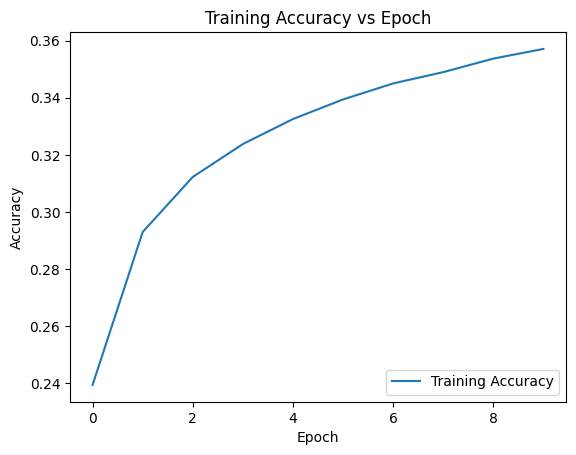

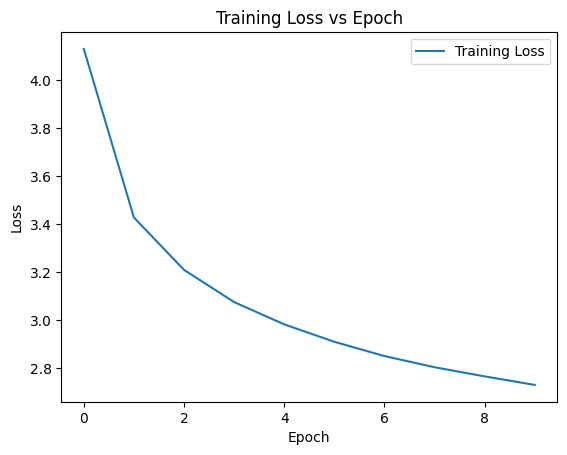

In [38]:
# Plot accuracy
plt.plot(all_train_acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Training Accuracy vs Epoch")
plt.show()

# Plot loss
plt.plot(all_train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("Training Loss vs Epoch")
plt.show()


In [39]:
model.save_weights('model_33.h5')

In [31]:
model.load_weights('model_33.h5')

The code snippet defines a `greedySearch` function, which employs a greedy approach to generate captions for input images. The function takes the image `photo` as input and initializes the variable `in_text` with the token 'startseq', indicating the beginning of the caption. Within a loop that iterates over the maximum length of the sequences, the function processes the current `in_text` by converting it into a sequence of word indices using the `wordtoix` dictionary and padding the sequence to match the maximum length. The model predicts the next word in the sequence based on the provided photo and current sequence, utilizing the `model.predict` function. The predicted word is determined by selecting the word with the highest probability, obtained using the `np.argmax` function. The word corresponding to the predicted index is retrieved from the `ixtoword` dictionary. The generated word is then appended to the `in_text`, and the process continues until the 'endseq' token is encountered, signaling the completion of the caption. The function extracts the generated caption, removes the 'startseq' and 'endseq' tokens, and formats the words into a coherent sentence, which is returned as the final caption for the input image.


In [32]:
images = ''
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

Image path: 3432550415_e7b77232de.jpg


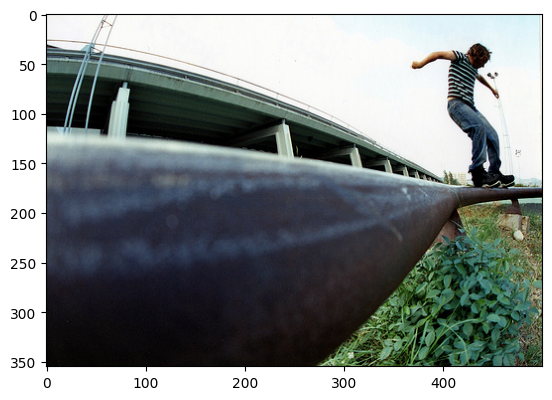

Greedy: boy is sliding down metal slide
BLEU Score1: 0.5
BLEU Score2: 0.2
Image path: 3259002340_707ce96858.jpg


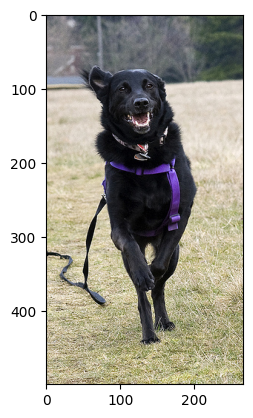

Greedy: black dog is running through the grass
BLEU Score1: 0.8571428571428571
BLEU Score2: 0.6666666666666666
Image path: 498444334_a680d318a1.jpg


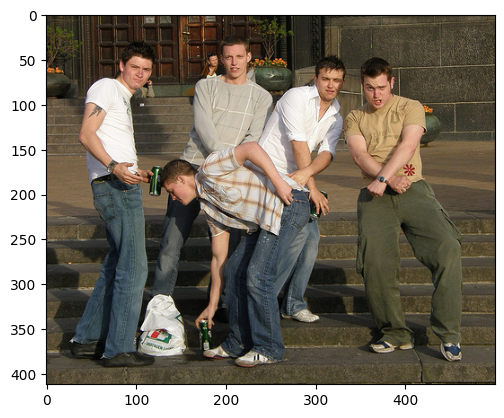

Greedy: group of people are standing on bench
BLEU Score1: 0.42857142857142855
BLEU Score2: 0.16666666666666669
Image path: 136644343_0e2b423829.jpg


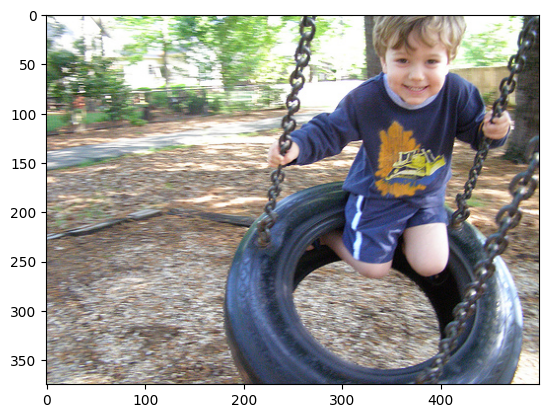

Greedy: boy in red shirt is swinging on swing
BLEU Score1: 0.625
BLEU Score2: 0.2857142857142857
Image path: 537559285_29be110134.jpg


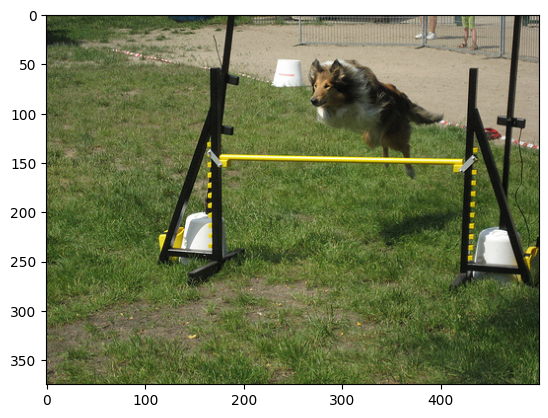

Greedy: dog jumps over hurdle
BLEU Score1: 0.45489799478447507
BLEU Score2: 0.2021768865708778
Image path: 2461616306_3ee7ac1b4b.jpg


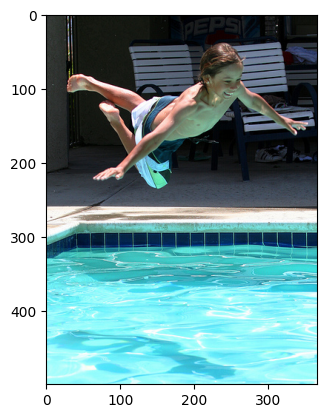

Greedy: boy jumps into pool
BLEU Score1: 0.7788007830714049
BLEU Score2: 0.7788007830714049
Image path: 997722733_0cb5439472.jpg


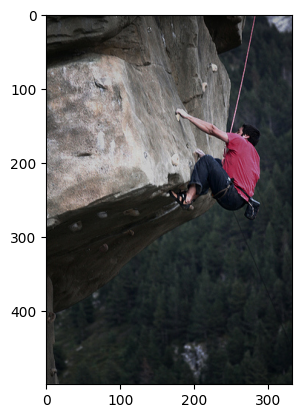

Greedy: man in red shirt climbs rock
BLEU Score1: 1.0
BLEU Score2: 1.0
Image path: 172097782_f0844ec317.jpg


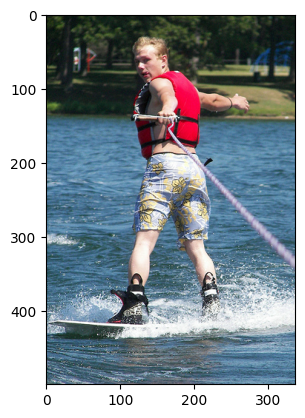

Greedy: man in black wetsuit is waterskiing in lake
BLEU Score1: 0.5
BLEU Score2: 0.2857142857142857
Image path: 3572267708_9d8a81d4a4.jpg


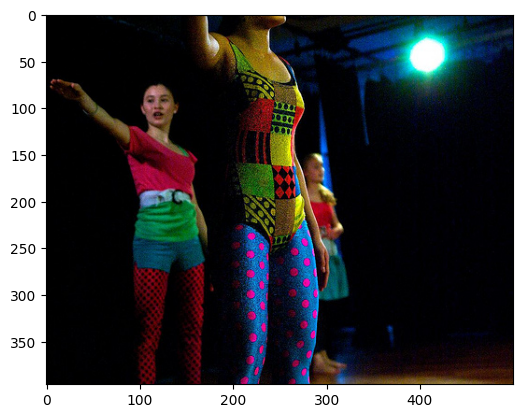

Greedy: group of young people dance in front of crowd
BLEU Score1: 0.2982797722714565
BLEU Score2: 0.11185491460179624
Image path: 2215136723_960edfea49.jpg


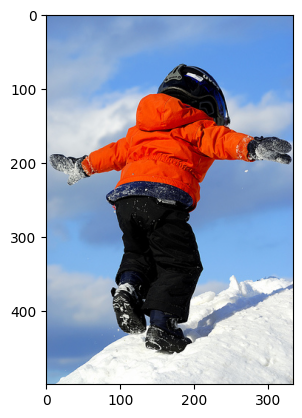

Greedy: boy in red coat and black pants is jumping over snow
BLEU Score1: 0.6363636363636364
BLEU Score2: 0.2


In [55]:
image_paths = random.sample(list(encoding_test.keys()), 10)
for image_path in image_paths:
    image = encoding_test[image_path].reshape((1, 2048))
    x = plt.imread('/home/aakash/Documents/Automated_Image_Captioning-master/flickr8k-sau/Flickr_Data/Images/'+ image_path)
    print("Image path:", image_path)
    plt.imshow(x)
    plt.show()
    predicted_caption = greedySearch(image)
    print("Greedy:", predicted_caption)
    image_path=image_path[:-4]
    # print(descriptions[image_path])
    reference= [description.split() for description in descriptions[image_path]]
    # print(reference)
    smoothie = SmoothingFunction().method0
    bleu_score1 = sentence_bleu(reference, predicted_caption.split(),weights=(1,0,0,0),smoothing_function=smoothie)
    bleu_score2 = sentence_bleu(reference, predicted_caption.split(),weights=(0,1,0,0),smoothing_function=smoothie)
    print("BLEU Score1:", bleu_score1)
    print("BLEU Score2:", bleu_score2)

In [43]:
from gtts import gTTS
for image_path in image_paths:
    image = encoding_test[image_path].reshape((1, 2048))
    predicted_caption = greedySearch(image)
    
    # Convert text to speech
    tts = gTTS(predicted_caption)
    # Save the converted audio file for each caption in the loop
    tts.save(os.getcwd()+'/audio/'+image_path+'.mp3')

The following code calculate the following scores for the test dataset:
<ol>
  <li>Average BLEU-1</li>
  <li>Average BLEU-2</li>
  <li>Average BLEU-3</li>
  <li>Average BLEU-4</li>
  <li>Average overall BLEU Score</li>
</ol>

And we also plotted the bar graph for the same

In [44]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import random

def calculate_average_bleu_scores(encoding_test, greedySearch, descriptions):
    # Set up smoothing function for BLEU score
    smoothing = SmoothingFunction().method1

    # Initialize lists to store individual BLEU scores
    bleu1_scores = []
    bleu2_scores = []
    bleu3_scores = []
    bleu4_scores = []
    bleu_scores=[]

    # Randomly select image paths
    image_paths = encoding_test.keys()

    for image_path in image_paths:
        image = encoding_test[image_path].reshape((1, 2048))

        # Display the image
        x = plt.imread('/home/aakash/Documents/Automated_Image_Captioning-master/flickr8k-sau/Flickr_Data/Images/' + image_path)
        # print("Image path:", image_path)
        # plt.imshow(x)
        # plt.show()

        # Generate predicted caption
        predicted_caption = greedySearch(image)
        # print("Greedy:", predicted_caption)

        # Prepare reference captions
        image_path_without_extension = image_path[:-4]
        reference_captions = [description.split() for description in descriptions[image_path_without_extension]]

        # Calculate BLEU scores
        bleu = sentence_bleu(reference_captions, predicted_caption.split(), smoothing_function=smoothing)
        bleu1 = sentence_bleu(reference_captions, predicted_caption.split(), smoothing_function=smoothing, weights=(1, 0, 0, 0))
        bleu2 = sentence_bleu(reference_captions, predicted_caption.split(), smoothing_function=smoothing, weights=(0.5, 0.5, 0, 0))
        bleu3 = sentence_bleu(reference_captions, predicted_caption.split(), smoothing_function=smoothing, weights=(0.33, 0.33, 0.33, 0))
        bleu4 = sentence_bleu(reference_captions, predicted_caption.split(), smoothing_function=smoothing, weights=(0.25, 0.25, 0.25, 0.25))
        
        # Append individual BLEU scores to lists
        bleu1_scores.append(bleu1)
        bleu2_scores.append(bleu2)
        bleu3_scores.append(bleu3)
        bleu4_scores.append(bleu4)
        bleu_scores.append(bleu)

    # Calculate average BLEU scores
    average_bleu1 = sum(bleu1_scores) / len(bleu1_scores)
    average_bleu2 = sum(bleu2_scores) / len(bleu2_scores)
    average_bleu3 = sum(bleu3_scores) / len(bleu3_scores)
    average_bleu4 = sum(bleu4_scores) / len(bleu4_scores)
    average_bleu=sum(bleu_scores)/len(bleu_scores)

    return average_bleu,average_bleu1, average_bleu2, average_bleu3, average_bleu4

average_bleu,average_bleu1, average_bleu2, average_bleu3, average_bleu4= calculate_average_bleu_scores(encoding_test, greedySearch, descriptions)
print(f'Average BLEU-1: {average_bleu1}')
print(f'Average BLEU-2: {average_bleu2}')
print(f'Average BLEU-3: {average_bleu3}')
print(f'Average BLEU-4: {average_bleu4}')
print(f'Average BLEU: {average_bleu}')


Average BLEU-1: 0.4702983902699673
Average BLEU-2: 0.2712643036064669
Average BLEU-3: 0.16487207841542234
Average BLEU-4: 0.1061687628767329
Average BLEU: 0.1061687628767329


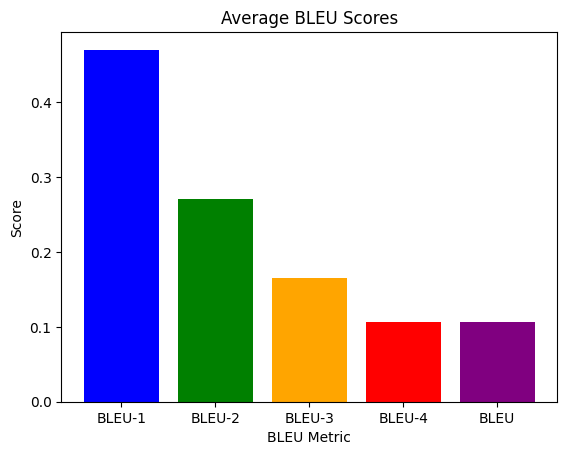

In [45]:
labels = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'BLEU']
scores = [average_bleu1, average_bleu2, average_bleu3, average_bleu4, average_bleu]

plt.bar(labels, scores, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.title('Average BLEU Scores')
plt.xlabel('BLEU Metric')
plt.ylabel('Score')
plt.show()